<a href="https://colab.research.google.com/github/pedromonteiro18/HistologyDetectron/blob/main/Histology_Detectron2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install detectron2

In [ ]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

1.7.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.7)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.7")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Run a pre-trained detectron2 model

We first download an image from the COCO dataset:

In [ ]:
im = cv2.imread("/content/drive/My Drive/Colab Notebooks/Histology/sample tissue/s19.png")
# cv2_imshow(im)

Then, we create a detectron2 config and a detectron2 `DefaultPredictor` to run inference on this image.

In [ ]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

In [ ]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([], device='cuda:0', dtype=torch.int64)
Boxes(tensor([], device='cuda:0', size=(0, 4)))


In [ ]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
# cv2_imshow(out.get_image()[:, :, ::-1])

# Train on a custom dataset

Register dataset

In [ ]:
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/content/drive/My Drive/Colab Notebooks/Histology/Histology COCO/Histology.json", "/content/drive/My Drive/Colab Notebooks/Histology/Histology COCO/")
register_coco_instances("my_dataset_val", {}, "/content/drive/My Drive/Colab Notebooks/Histology/Histology COCO Test/Histology Test.json", "/content/drive/My Drive/Colab Notebooks/Histology/Histology COCO Test/Images")

AssertionError: ignored

In [ ]:
trainDict = DatasetCatalog.get("my_dataset_train")
testDict = DatasetCatalog.get("my_dataset_val")

[01/02 22:07:34 d2.data.datasets.coco]: Loaded 4 images in COCO format from /content/drive/My Drive/Colab Notebooks/Histology/Histology COCO/Histology.json
[01/02 22:07:34 d2.data.datasets.coco]: Loaded 1 images in COCO format from /content/drive/My Drive/Colab Notebooks/Histology/Histology COCO Test/Histology Test.json


In [ ]:
# # if your dataset is in COCO format, this cell can be replaced by the following three lines:
# # from detectron2.data.datasets import register_coco_instances
# # register_coco_instances("my_dataset_train", {}, "json_annotation_train.json", "path/to/image/dir")
# # register_coco_instances("my_dataset_val", {}, "json_annotation_val.json", "path/to/image/dir")

# from detectron2.structures import BoxMode

# def get_balloon_dicts(img_dir):
#     json_file = os.path.join(img_dir, "via_region_data.json")
#     with open(json_file) as f:
#         imgs_anns = json.load(f)

#     dataset_dicts = []
#     for idx, v in enumerate(imgs_anns.values()):
#         record = {}
        
#         filename = os.path.join(img_dir, v["filename"])
#         height, width = cv2.imread(filename).shape[:2]
        
#         record["file_name"] = filename
#         record["image_id"] = idx
#         record["height"] = height
#         record["width"] = width
      
#         annos = v["regions"]
#         objs = []
#         for _, anno in annos.items():
#             assert not anno["region_attributes"]
#             anno = anno["shape_attributes"]
#             px = anno["all_points_x"]
#             py = anno["all_points_y"]
#             poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
#             poly = [p for x in poly for p in x]

#             obj = {
#                 "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
#                 "bbox_mode": BoxMode.XYXY_ABS,
#                 "segmentation": [poly],
#                 "category_id": 0,
#             }
#             objs.append(obj)
#         record["annotations"] = objs
#         dataset_dicts.append(record)
#     return dataset_dicts

# for d in ["train", "val"]:
#     DatasetCatalog.register("balloon_" + d, lambda d=d: get_balloon_dicts("balloon/" + d))
#     MetadataCatalog.get("balloon_" + d).set(thing_classes=["balloon"])
histology_metadata = MetadataCatalog.get("my_dataset_train")

To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



In [ ]:
dataset_dicts = trainDict
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=histology_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

NameError: ignored

## Train!

Now, let's fine-tune a COCO-pretrained R50-FPN Mask R-CNN model on the balloon dataset. It takes ~6 minutes to train 300 iterations on Colab's K80 GPU, or ~2 minutes on a P100 GPU.


In [ ]:
from detectron2.engine import DefaultTrainer

# for el in trainDict:
#   print(el['annotations'][0]['segmentation'])
#   print(len(el['annotations'][0]['segmentation']))
#   for r in range(len(el['annotations'])):
#     for i in range(len(el['annotations'][r]['segmentation'])):
#       el['annotations'][r]['segmentation'][i] = [int(i) for i in el['annotations'][r]['segmentation'][i]]
#       print([int(i) for i in el['annotations'][r]['segmentation'][i]])
#     # for key, value in el.items() :
#     #     print (key, value)
#   print(el)

# for el in trainDict:
#   print(el)

CUDA_LAUNCH_BLOCKING=1
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.0025  # learning rate
cfg.SOLVER.MAX_ITER = 300    # number of iterations
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 4   # faster, (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # number of classes

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[01/02 22:08:09 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

[01/02 22:08:14 d2.engine.train_loop]: Starting training from iteration 0
[01/02 22:08:42 d2.utils.events]:  eta: 0:06:07  iter: 19  total_loss: 2.937  loss_cls: 1.268  loss_box_reg: 0.9798  loss_mask: 0.6869  loss_rpn_cls: 0.01434  loss_rpn_loc: 0.02452  time: 1.3033  data_time: 0.9548  lr: 4.9952e-05  max_mem: 3463M
[01/02 22:09:08 d2.utils.events]:  eta: 0:05:40  iter: 39  total_loss: 2.24  loss_cls: 0.6734  loss_box_reg: 0.8695  loss_mask: 0.6001  loss_rpn_cls: 0.009646  loss_rpn_loc: 0.02398  time: 1.3081  data_time: 0.8891  lr: 9.9902e-05  max_mem: 3463M
[01/02 22:09:34 d2.utils.events]:  eta: 0:05:12  iter: 59  total_loss: 1.918  loss_cls: 0.4634  loss_box_reg: 0.9569  loss_mask: 0.4946  loss_rpn_cls: 0.002028  loss_rpn_loc: 0.0242  time: 1.2959  data_time: 0.8589  lr: 0.00014985  max_mem: 3463M
[01/02 22:09:59 d2.utils.events]:  eta: 0:04:45  iter: 79  total_loss: 1.752  loss_cls: 0.3296  loss_box_reg: 0.8899  loss_mask: 0.447  loss_rpn_cls: 0.001407  loss_rpn_loc: 0.01828  tim

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

<IPython.core.display.Javascript object>

## Inference & evaluation using the trained model
Now, let's run inference with the trained model on the balloon validation dataset. First, let's create a predictor using the model we just trained:



In [ ]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

Then, we randomly select several samples to visualize the prediction results.

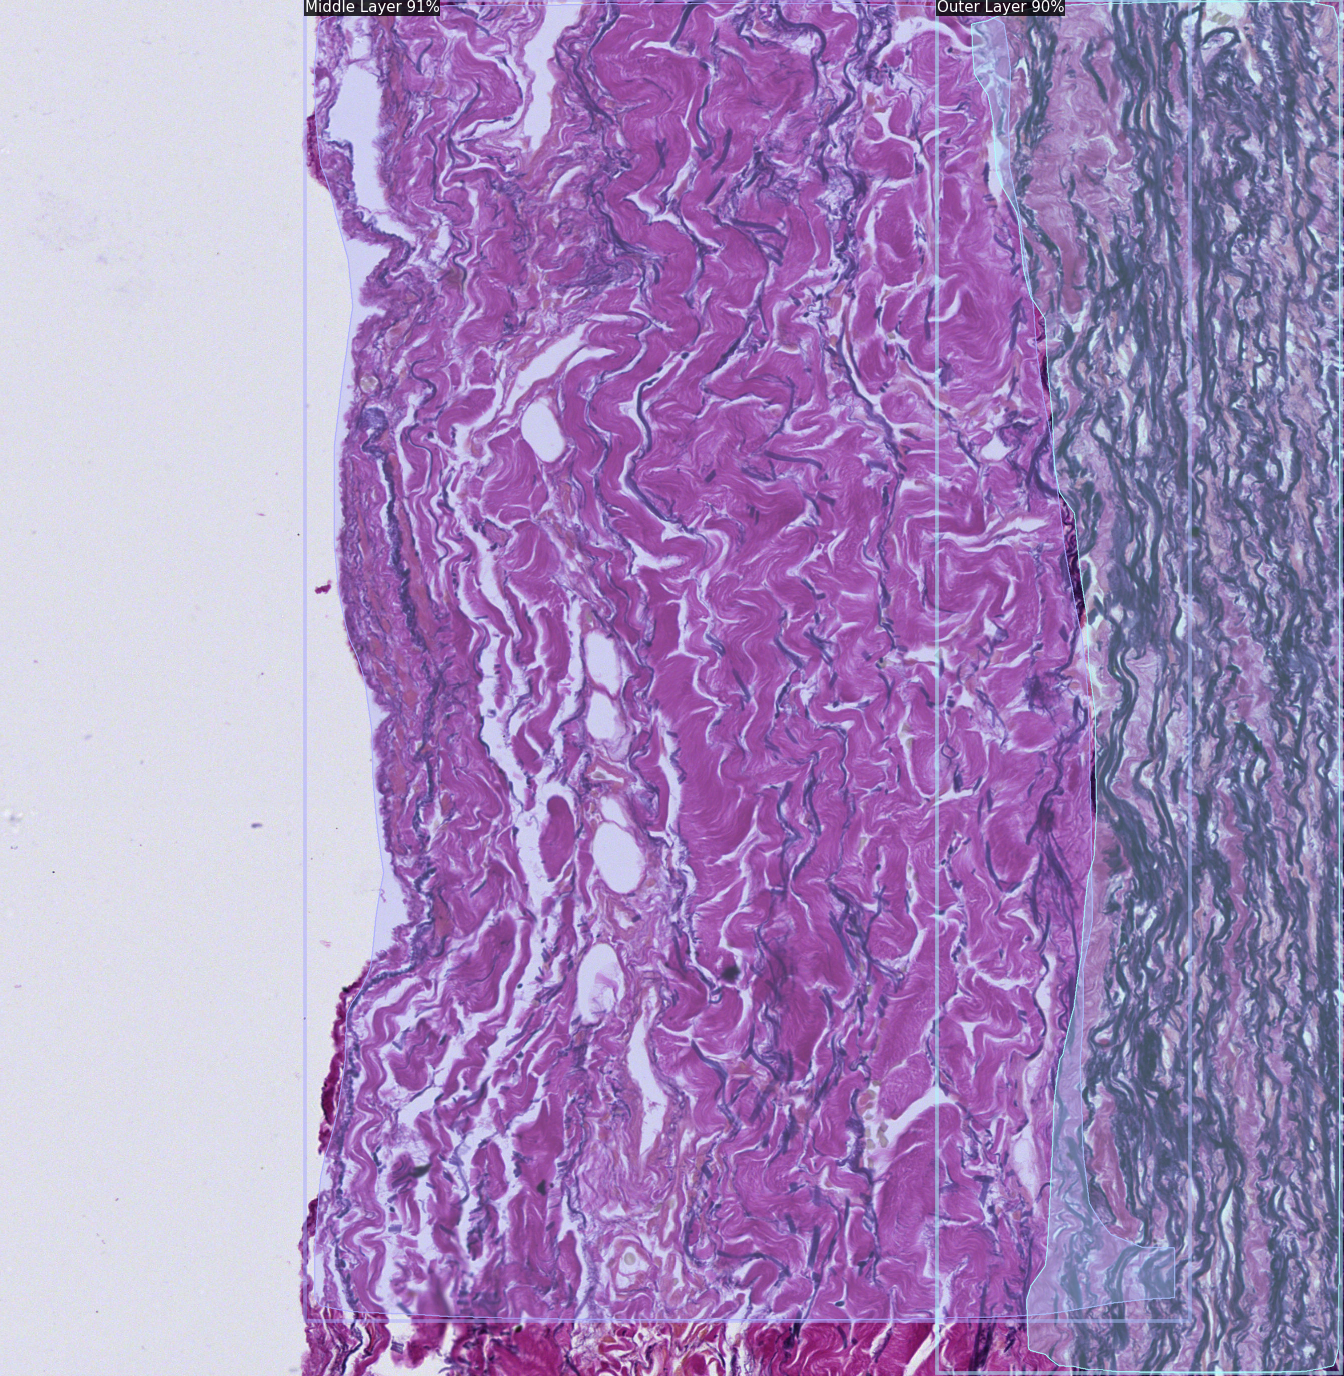

In [ ]:
from detectron2.utils.visualizer import ColorMode
# dataset_dicts = get_balloon_dicts("balloon/val")
dataset_dicts = testDict
for d in random.sample(dataset_dicts, 1):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=histology_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

We can also evaluate its performance using AP metric implemented in COCO API.
This gives an AP of ~70. Not bad!

In [ ]:
# from detectron2.evaluation import COCOEvaluator, inference_on_dataset
# from detectron2.data import build_detection_test_loader
# evaluator = COCOEvaluator("balloon_val", ("bbox", "segm"), False, output_dir="./output/")
# val_loader = build_detection_test_loader(cfg, "balloon_val")
# print(inference_on_dataset(trainer.model, val_loader, evaluator))
# # another equivalent way to evaluate the model is to use `trainer.test`

# Other types of builtin models

In [ ]:
# # Inference with a keypoint detection model
# cfg = get_cfg()   # get a fresh new config
# cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
# cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
# predictor = DefaultPredictor(cfg)
# outputs = predictor(im)
# v = Visualizer(im[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
# out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
# cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
# # Inference with a panoptic segmentation model
# cfg = get_cfg()
# cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
# predictor = DefaultPredictor(cfg)
# panoptic_seg, segments_info = predictor(im)["panoptic_seg"]
# v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
# out = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
# cv2_imshow(out.get_image()[:, :, ::-1])